In [ ]:
import numpy as np
from scipy.special import erf
from scipy.optimize import minimize


def completeness_model(m, m50, sigma_comp):
    """Error function completeness model"""
    return 0.5 * (1 + erf((m50 - m) / (np.sqrt(2) * sigma_comp)))

def negative_log_likelihood(theta, m_bins, N_add, N_rec):
    """
    Negative log-likelihood for binomial model.
    We minimize the negative to maximize the likelihood.
    """
    m50, sigma_comp = theta
    
    # Compute model completeness at each magnitude
    C = completeness_model(m_bins, m50, sigma_comp)
    
    # Clip to avoid log(0)
    C = np.clip(C, 1e-10, 1 - 1e-10)
    
    # Binomial log-likelihood (without constant terms)
    log_L = np.sum(N_rec * np.log(C) + (N_add - N_rec) * np.log(1 - C))
    
    return -log_L  # Return negative for minimization

# Example data
m_bins = np.array([19.0, 20.5, 22.0])
N_add = np.array([100, 100, 100])
N_rec = np.array([98, 73, 12])

# Initial guess
theta_init = [21.0, 1.0]

# Minimize negative log-likelihood
result = minimize(negative_log_likelihood, theta_init, 
                  args=(m_bins, N_add, N_rec),
                  method='Nelder-Mead')

m50_best, sigma_comp_best = result.x
print(f"Best fit: m50 = {m50_best:.2f}, sigma_comp = {sigma_comp_best:.2f}")

# Estimate uncertainties from Hessian
from scipy.optimize import approx_fprime

def nll(theta):
    return negative_log_likelihood(theta, m_bins, N_add, N_rec)

# Compute Hessian numerically
eps = 1e-5
hessian = np.zeros((2, 2))
for i in range(2):
    for j in range(2):
        # Second derivative approximation
        theta_pp = result.x.copy()
        theta_pm = result.x.copy()
        theta_mp = result.x.copy()
        theta_mm = result.x.copy()
        
        theta_pp[i] += eps
        theta_pp[j] += eps
        
        theta_pm[i] += eps
        theta_pm[j] -= eps
        
        theta_mp[i] -= eps
        theta_mp[j] += eps
        
        theta_mm[i] -= eps
        theta_mm[j] -= eps
        
        hessian[i,j] = (nll(theta_pp) - nll(theta_pm) - nll(theta_mp) + nll(theta_mm)) / (4*eps**2)

# Covariance is inverse of Hessian (Fisher information)
cov = np.linalg.inv(hessian)
uncertainties = np.sqrt(np.diag(cov))

print(f"Uncertainties: sigma_m50 = {uncertainties[0]:.2f}, sigma_sigma_comp = {uncertainties[1]:.2f}")

Best fit: m50 = 20.99, sigma_comp = 0.89
Uncertainties: sigma_m50 = 0.09, sigma_sigma_comp = 0.08


100%|██████████| 5000/5000 [00:05<00:00, 848.11it/s]


m50 = 20.99 +0.09 -0.09


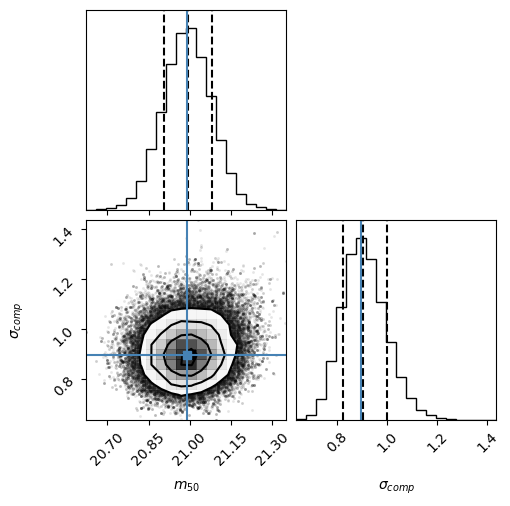

In [ ]:
import emcee
import corner  # For visualization

def log_prior(theta):
    m50, sigma_comp = theta
    # Gaussian prior on m50
    lp_m50 = -0.5 * ((m50 - 21.0) / 1.5)**2
    # Half-normal prior on sigma_comp
    if sigma_comp > 0:
        lp_sigma = -0.5 * (sigma_comp / 1.0)**2
    else:
        return -np.inf
    return lp_m50 + lp_sigma

def log_likelihood(theta, m_bins, N_add, N_rec):
    m50, sigma_comp = theta
    C = completeness_model(m_bins, m50, sigma_comp)
    C = np.clip(C, 1e-10, 1 - 1e-10)
    return np.sum(N_rec * np.log(C) + (N_add - N_rec) * np.log(1 - C))

def log_probability(theta, m_bins, N_add, N_rec):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, m_bins, N_add, N_rec)

# Set up the sampler
ndim = 2  # number of parameters
nwalkers = 32  # number of MCMC walkers
nsteps = 5000  # number of steps

# Initialize walkers near MLE result
pos = result.x + 1e-2 * np.random.randn(nwalkers, ndim)

# Run MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                args=(m_bins, N_add, N_rec))
sampler.run_mcmc(pos, nsteps, progress=True)

# Discard burn-in (first 1000 steps)
samples = sampler.get_chain(discard=1000, flat=True)

# Analyze results
m50_samples = samples[:, 0]
sigma_comp_samples = samples[:, 1]

# Median and credible intervals
m50_median = np.median(m50_samples)
m50_16, m50_84 = np.percentile(m50_samples, [16, 84])

print(f"m50 = {m50_median:.2f} +{m50_84-m50_median:.2f} -{m50_median-m50_16:.2f}")

# Make corner plot
fig = corner.corner(samples, labels=["$m_{50}$", "$\sigma_{comp}$"],
                    truths=[m50_best, sigma_comp_best],
                    quantiles=[0.16, 0.5, 0.84])

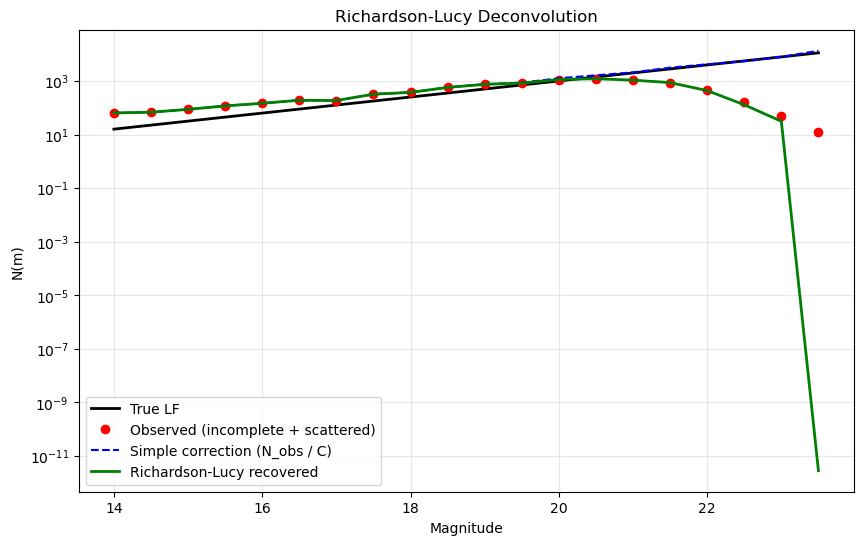

In [6]:
import matplotlib.pyplot as plt

def richardson_lucy(N_obs, completeness, sigma_phot, m_bins, n_iterations=50):
    """
    Richardson-Lucy deconvolution for luminosity function.
    
    Parameters:
    -----------
    N_obs : array
        Observed star counts in magnitude bins
    completeness : array
        Completeness function C(m) at each bin
    sigma_phot : array
        Photometric uncertainty at each magnitude
    m_bins : array
        Magnitude bin centers
    n_iterations : int
        Number of RL iterations
    
    Returns:
    --------
    N_true : array
        Deconvolved true star counts
    """
    n_bins = len(m_bins)
    dm = m_bins[1] - m_bins[0]
    
    # Build kernel matrix K[i,j] = probability that star at true mag m_j 
    # is observed at mag m_i
    K = np.zeros((n_bins, n_bins))
    for i in range(n_bins):
        for j in range(n_bins):
            # Gaussian photometric scatter
            scatter_prob = np.exp(-(m_bins[i] - m_bins[j])**2 / (2 * sigma_phot[j]**2))
            scatter_prob /= (np.sqrt(2 * np.pi) * sigma_phot[j])
            # Include completeness and bin width
            K[i, j] = completeness[j] * scatter_prob * dm
    
    # Initialize: assume observed = true (zeroth order approximation)
    N_true = N_obs.copy()
    
    # Richardson-Lucy iterations
    for iteration in range(n_iterations):
        # Forward model: what would we observe given current N_true?
        N_model = K @ N_true
        
        # Avoid division by zero
        N_model = np.maximum(N_model, 1e-10)
        
        # Correction ratio
        ratio = N_obs / N_model
        
        # Backward correction
        correction = K.T @ ratio
        N_true = N_true * correction
    
    return N_true

# Example usage
m_bins = np.arange(14, 24, 0.5)
n_bins = len(m_bins)

# Simulate "true" luminosity function (power law)
alpha = 0.3
N_true_actual = 1000 * 10**(alpha * (m_bins - 20))

# Completeness function (error function)
m50 = 21.0
sigma_comp = 0.8
completeness = 0.5 * (1 + erf((m50 - m_bins) / (np.sqrt(2) * sigma_comp)))

# Photometric uncertainties (increasing with magnitude)
sigma_phot = 0.05 + 0.02 * (m_bins - 14)

# Simulate observations
# 1. Apply photometric scatter
N_scattered = np.zeros(n_bins)
for j in range(n_bins):
    for i in range(n_bins):
        scatter_prob = np.exp(-(m_bins[i] - m_bins[j])**2 / (2 * sigma_phot[j]**2))
        scatter_prob /= (np.sqrt(2 * np.pi) * sigma_phot[j])
        N_scattered[i] += N_true_actual[j] * scatter_prob * (m_bins[1] - m_bins[0])

# 2. Apply completeness
N_obs = np.random.poisson(N_scattered * completeness)

# Run Richardson-Lucy deconvolution
N_true_recovered = richardson_lucy(N_obs, completeness, sigma_phot, m_bins, n_iterations=50)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(m_bins, N_true_actual, 'k-', lw=2, label='True LF')
plt.plot(m_bins, N_obs, 'ro', label='Observed (incomplete + scattered)')
plt.plot(m_bins, N_obs / completeness, 'b--', label='Simple correction (N_obs / C)')
plt.plot(m_bins, N_true_recovered, 'g-', lw=2, label='Richardson-Lucy recovered')
plt.xlabel('Magnitude')
plt.ylabel('N(m)')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.title('Richardson-Lucy Deconvolution')
plt.show()

## Step 1: Take Data

Multi-exposure images of M2 and M34

## Step 2: Photometry

Extract sources, measure magnitudes and positions

## Step 3: Artificial Star Tests

Add fake stars, run photometry, measure recovery fractions

## Step 4: Fit Completeness Function

- Method A (Quick): Least-squares fit to $C(m)$
- Method B (Better): Maximum likelihood with binomial statistics
- Method C (Best): Bayesian MCMC with full posteriors

## Step 5: Correct Observed Counts

- Method A (Simple): $N_{\text{true}} = N_{\text{obs}} / C(m)$
- Method B (Better): Richardson-Lucy deconvolution

## Step 6: Build Density Profile

- Bin stars by radius
- Apply completeness corrections
- Propagate uncertainties

## Step 7: Fit Physical Models

Plummer, King, or Wilson profiles
Extract core radius, concentration, etc.